In [1]:
from scipy.interpolate import griddata

In [10]:
import matplotlib.pyplot as plt
import numpy as np
import math

# Define parameters for the DAS algorithm
Nmics = 8  # Number of microphones
Nsamples = 50  # Number of samples to be collected
src = (0, 0)  # Source location coordinates
pitch = 0.1  # Distance between microphones in the array
dist_per_sample = 0.1  # Distance each sample represents for time delay calculations
Nsamp = 200  # Number of total samples to process in each microphone
samp = Nsamp * dist_per_sample  # Total sampling distance range
C = 0.5  # Speed of wave propagation
sincP_1 = 1.25  # Parameter for the sinc function in signal calculation
sincP_2 = (
    5.0  # Second parameter for sinc (not used here but often part of signal adjustment)
)
mics = []  # List to store microphone positions
obstacle = (3, -1)  # Position of an obstacle in the field


def wsrc(t, sincP):
    """
    Generate a signal value at time `t` using a sinc function with a parameter `sincP`.

    Parameters:
    t (float): Time or distance variable for the sinc function.
    sincP (float): Sinc function parameter to adjust the frequency of the source signal.

    Returns:
    float: Amplitude of the sinc signal at time `t`.
    """
    return np.sinc(sincP * t)  # Using the sinc function for signal generation

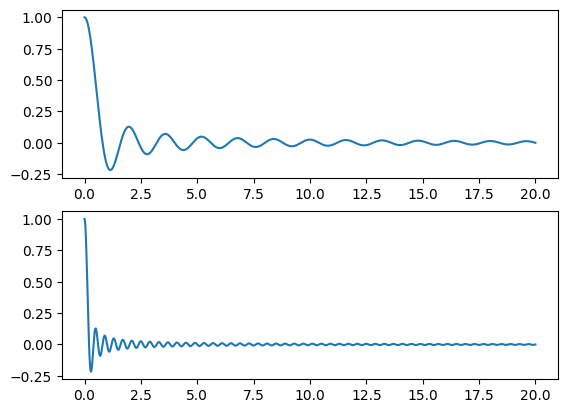

In [3]:
x = np.linspace(0, samp, 1000)
y_1 = wsrc(x, sincP_1)
y_2 = wsrc(x, sincP_2)
plt.subplot(2, 1, 1)
plt.plot(x, y_1)
plt.subplot(2, 1, 2)
plt.plot(x, y_2)
plt.show()

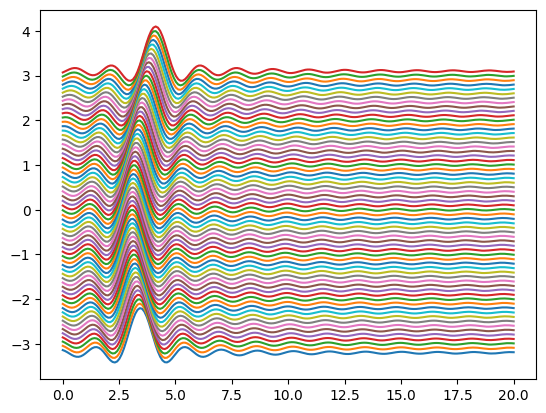

In [11]:
import matplotlib.pyplot as plt
import numpy as np
import math

# Initialize microphone and amplitude data
mics = []
amplitudes = []


def dist(src, pt, mic):
    """
    Calculate the total distance between the source, a point in the grid, and a microphone.

    Parameters:
    src (tuple): Source coordinates.
    pt (tuple): Target point in the grid.
    mic (tuple): Microphone coordinates.

    Returns:
    float: Combined distance from source to point and from point to microphone.
    """
    d1 = eucl_dist(mic, pt)
    d2 = eucl_dist(src, pt)
    return d1 + d2


# DAS algorithm parameters
Nmics = 64  # Number of microphones
Nsamp = 200  # Number of samples per signal
pitch = 0.1  # Distance between each microphone
C = 2.0  # Wave propagation speed
Obstacle = (3, -1)  # Position of an obstacle in the grid


def eucl_dist(p1, p2):
    """Calculate Euclidean distance between two points."""
    return math.sqrt((p1[0] - p2[0]) ** 2 + (p1[1] - p2[1]) ** 2)


def time_delay(i, Obstacle):
    """
    Compute the time delay based on the distance between microphone i and an obstacle.

    Parameters:
    i (int): Index of the microphone.
    Obstacle (tuple): Position of the obstacle.

    Returns:
    tuple: y-coordinate of the microphone, calculated time delay.
    """
    y = i * pitch
    t = (eucl_dist((0, y), Obstacle) + eucl_dist((0, 0), Obstacle)) / C
    return y, t


x = np.linspace(0, Nsamp * dist_per_sample, Nsamp)
grid_data = []

# Calculate amplitudes at grid points using time delays
for i in range(-1 * Nmics // 2, Nmics // 2, 1):
    y, t = time_delay(i, Obstacle)
    mics.append((0, y))
    for j in range(len(x)):
        amplitudes.append(wsrc(x[j] - t, sincP_1))  # Store amplitude with delay effect
        grid_data.append((x[j], y))  # Store grid point for plotting
    plt.plot(x, y + wsrc(x - t, sincP_1))

# Convert lists to numpy arrays for further processing
mics = np.array(mics)
amplitudes = np.array(amplitudes)
grid_data = np.array(grid_data)

plt.show()

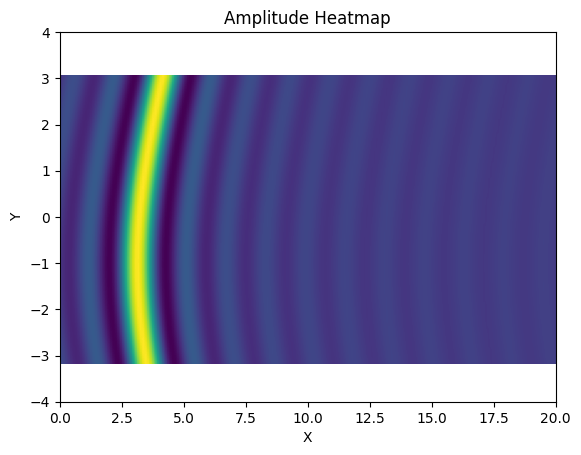

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata

# Assuming 'mics', 'amplitudes', and 'grid_data' have been generated from previous steps
# where 'grid_data' contains (x, y) positions and 'amplitudes' contains corresponding amplitude values

# Define the grid boundaries for interpolation
grid_x, grid_y = np.mgrid[
    0:samp:200j, (-1) * pitch * Nmics // 2 : pitch * Nmics // 2 + 1 : 200j
]
# Creates a 200x200 grid over the specified range in x and y directions

# Reshape the grid into a list of coordinate pairs for interpolation
mesh_points = np.vstack([grid_x.ravel(), grid_y.ravel()]).T

# Interpolate the amplitude data onto the grid points using cubic interpolation
grid_amplitudes = griddata(grid_data, amplitudes, mesh_points, method="cubic")

# Reshape interpolated amplitude data back to the grid format for plotting
grid_amplitudes = grid_amplitudes.reshape(200, 200)

# Plot the heatmap
plt.imshow(
    grid_amplitudes.T,
    extent=(0, samp, (-1) * pitch * Nmics // 2, pitch * Nmics // 2 + 1),
    origin="lower",
    cmap="viridis",
    aspect="auto",
)
plt.title("Amplitude Heatmap")
plt.xlabel("X")
plt.ylabel("Y")
plt.show()

In [14]:
import numpy as np

# Constants for DAS algorithm
Nsamp = 200  # Number of samples per signal
Nmics = 64  # Number of microphones
samp = Nsamp * dist_per_sample
x_min, x_max = 0, samp
y_min, y_max = -pitch * Nmics // 2, pitch * Nmics // 2


# Function to create a 2D grid of points (x, y) for the mesh
def grid(Nx, Ny, stop=x_max):
    x_step = (x_max - x_min) / (Nx - 1)
    y_step = (y_max - y_min) / (Ny - 1)
    mesh_points = []
    for i in range(Nx):
        x = x_min + i * x_step
        if x > stop:
            break
        for j in range(Ny):
            y = y_min + j * y_step
            mesh_points.append((x, y))  # Append each (x, y) point to the mesh
    return mesh_points


# Generate mesh points using the custom grid function
mesh_points = grid(Nsamp, Nsamp)
mesh_points = np.array(mesh_points)

# Load signal data from 'rx2.txt'
data = np.loadtxt("rx2.txt")

# Calculate DAS amplitude at each mesh point
amplitudes_mesh = []
for coords in mesh_points:
    sum = 0
    for i in range(Nmics):
        # Calculate distance-based time delay for each microphone
        distance = dist(src, coords, mics[i])
        j = int(distance / dist_per_sample)  # Convert distance to sample index
        if j < Nsamp:
            sum += float(data[i][j])  # Sum the amplitudes
    amplitudes_mesh.append(sum)

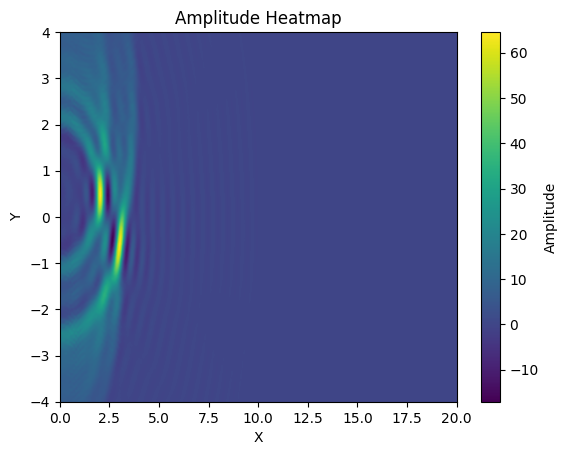

In [15]:
# Define a finer mesh for the 1000x1000 grid interpolation
mesh_points1 = grid(1000, 1000)

# Interpolate the amplitude data to the finer mesh grid
data_amplitudes = griddata(mesh_points, amplitudes_mesh, mesh_points1, method="cubic")

# Handle potential NaN values from interpolation
data_amplitudes = np.nan_to_num(data_amplitudes)

# Reshape interpolated data back to the grid shape
data_amplitudes = data_amplitudes.reshape(1000, 1000)

# Plot the heatmap
plt.imshow(
    data_amplitudes.T,
    extent=(0, samp, (-1) * pitch * Nmics // 2, pitch * Nmics // 2 + 1),
    origin="lower",
    cmap="viridis",
    aspect="auto",
)
plt.title("Amplitude Heatmap")
plt.xlabel("X")
plt.ylabel("Y")
plt.colorbar(label="Amplitude")  # Optional: Add a colorbar for scale
plt.show()

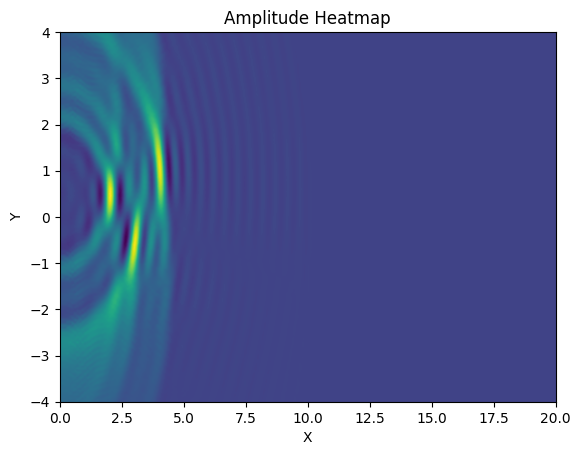

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata

# Constants and parameters
Nsamp = 200  # Number of samples per signal
Nmics = 64  # Number of microphones
samp = Nsamp * dist_per_sample  # Total number of samples per microphone signal
data = np.loadtxt("rx3.txt")  # Load the signal data from 'rx3.txt'

# Initialize a list to store the amplitudes for each mesh point
amplitudes_mesh = []

# Set to store unique x-sample values for potential later usage
xsample = set()

# Iterate over each mesh point in the mesh_points array
for coords in mesh_points:
    sum = 0
    # Loop over each microphone to compute the contribution to the amplitude at each mesh point
    for i in range(Nmics):
        # Calculate the distance from the microphone to the current mesh point and compute time delay
        distance = dist(src, coords, mics[i])
        j = int(distance / dist_per_sample)  # Convert the distance to a sample index
        if j < Nsamp:
            sum += float(data[i][j])  # Accumulate the signal amplitude at this point
            xsample.add(
                coords[0]
            )  # Add the x-coordinate to the xsample set (for later use)

    # Append the total amplitude for the current mesh point to the list
    amplitudes_mesh.append(sum)

# Interpolate the amplitudes onto the new grid using cubic interpolation
data_amplitudes = griddata(mesh_points, amplitudes_mesh, mesh_points1, method="cubic")

# Reshape the interpolated data to match the grid shape for plotting
data_amplitudes = data_amplitudes.reshape(1000, 1000)

# Plot the heatmap using imshow
# The 'extent' defines the x and y axis ranges, and 'origin' controls the image orientation
plt.imshow(
    data_amplitudes.T,
    extent=(0, samp, (-1) * pitch * Nmics // 2, pitch * Nmics // 2 + 1),
    origin="lower",
    cmap="viridis",
    aspect="auto",
)

# Set plot title and axis labels
plt.title("Amplitude Heatmap")
plt.xlabel("X")
plt.ylabel("Y")

# Show the plot
plt.show()

9.949748743718594


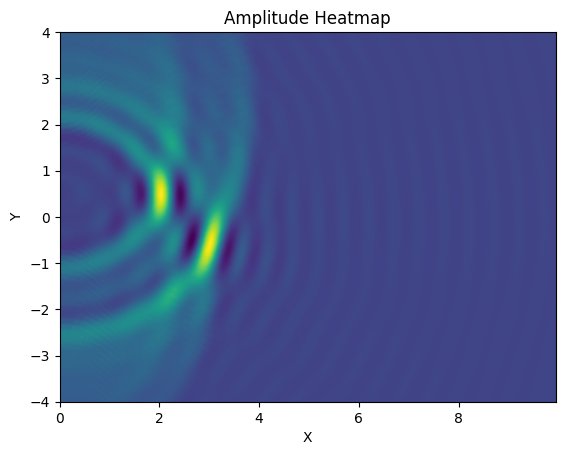

In [9]:
Nsamp = 200
Nmics = 64
x_max = max(xsample)
print(x_max)
samp = int((max(xsample) / dist_per_sample)) + 1
mesh_points = grid(Nsamp, Nsamp, samp)
mesh_points1 = grid(1000, 1000, samp)
data = np.loadtxt("rx2.txt")
amplitudes_mesh = []
for coords in mesh_points:
    sum = 0
    for i in range(Nmics):
        distance = dist(src, coords, mics[i])
        j = int(distance / dist_per_sample)
        if j < Nsamp:
            sum += float(data[i][j])

    amplitudes_mesh.append(sum)
data_amplitudes = griddata(mesh_points, amplitudes_mesh, mesh_points1, method="cubic")


# Reshape interpolated data back to the grid shape
data_amplitudes = data_amplitudes.reshape(1000, 1000)

# Plot the heatmap
plt.imshow(
    data_amplitudes.T,
    extent=(x_min, x_max, y_min, y_max + 1),
    origin="lower",
    cmap="viridis",
    aspect="auto",
)
plt.title("Amplitude Heatmap")
plt.xlabel("X")
plt.ylabel("Y")
plt.show()

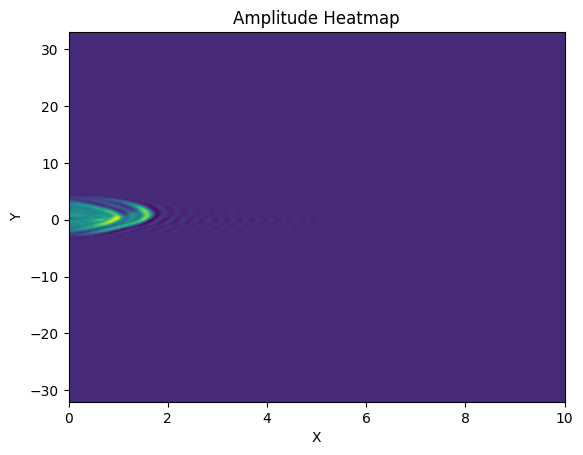

In [21]:
# Constants for the DAS algorithm
Nsamp = 200  # Number of samples per signal
Nmics = 64  # Number of microphones
samp = (
    Nsamp * dist_per_sample
)  # Calculate the total number of samples based on x_max and dist_per_sample
x_max = samp
# Generate mesh points for the grid using the custom grid function
mesh_points = grid(Nsamp, Nsamp, samp)  # Define the grid based on the number of samples
mesh_points1 = grid(
    1000, 1000, samp
)  # Define a finer grid for interpolation (1000x1000)

# Load signal data from 'rx2.txt'
data = np.loadtxt("rx2.txt")

# Initialize list to store computed amplitudes at each mesh point
amplitudes_mesh = []

# Loop over each mesh point to compute the total amplitude from the microphones
for coords in mesh_points:
    sum = 0  # Initialize a variable to accumulate the total amplitude for the current point
    # Loop over each microphone to compute the signal's contribution at this mesh point
    for i in range(Nmics):
        # Calculate distance from microphone to current mesh point and compute time delay
        distance = dist(src, coords, mics[i])
        j = int(
            distance / dist_per_sample
        )  # Convert distance to corresponding sample index
        if j < Nsamp:  # Ensure the sample index is within bounds
            sum += float(data[i][j])  # Accumulate the amplitude value

    # Append the computed total amplitude for the current mesh point
    amplitudes_mesh.append(sum)

# Interpolate the amplitudes onto a finer grid using cubic interpolation
data_amplitudes = griddata(mesh_points, amplitudes_mesh, mesh_points1, method="cubic")

# Reshape the interpolated data to match the grid shape for visualization (1000x1000 grid)
data_amplitudes = data_amplitudes.reshape(1000, 1000)

# Plot the heatmap of the amplitude data using imshow
plt.imshow(
    data_amplitudes.T,
    extent=(x_min, x_max, y_min, y_max + 1),
    origin="lower",
    cmap="viridis",
    aspect="auto",
)

# Set plot title and axis labels
plt.title("Amplitude Heatmap")
plt.xlabel("X")
plt.ylabel("Y")

# Show the plot
plt.show()